In [8]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error
#from qiskit_experiments import *
from qiskit.quantum_info import state_fidelity
from copy import deepcopy
from qiskit.visualization import plot_histogram

In [9]:
backend = AerSimulator()

noise_model = NoiseModel()
erro1 = depolarizing_error(0.01,1)
erro2 = depolarizing_error(0.02,2)

noise_model.add_all_qubit_quantum_error(erro1,['h','x','z'])
noise_model.add_all_qubit_quantum_error(erro2,['cx','swap'])

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile
import numpy as np

pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),        # X
    np.array([[0, -1.0j], [1.0j, 0.0]]),       # Y
    np.array([[1.0, 0.0], [0.0, -1.0]])        # Z
]

def measurement(base, input_circuit, target_qubit):
    """
    Cria uma cópia do circuito de entrada, aplica a rotação que diagonaliza
    o operador de Pauli desejado no qubit 'target_qubit' e mede esse qubit
    em um registrador clássico dedicado (ctomo[0]).
    Retorna (circuito_medicao, classical_bit_da_tomografia).
    """
    circ = input_circuit.copy()

    # Rotações para medir em X ou Y via base Z
    if base == 'X':
        circ.h(target_qubit)
    elif base == 'Y':
        circ.sdg(target_qubit)
        circ.h(target_qubit)

    # Registrador clássico dedicado para a tomografia
    ctomo = ClassicalRegister(1, 'ctomo')
    circ.add_register(ctomo)

    # Mede o qubit-alvo apenas em ctomo[0] (bit dedicado)
    circ.measure(target_qubit, ctomo[0])

    # Retorna também o ClassicalBit para localizá-lo depois
    return circ, ctomo[0]

def tomography(my_circuit, target_qubit, shots, backend, noise_model=None):
    """
    Executa medições em X, Y, Z do qubit 'target_qubit' usando um bit clássico
    dedicado. Marginaliza exatamente esse bit para computar ⟨X⟩, ⟨Y⟩, ⟨Z⟩.
    """
    expectation_values = {}
    all_counts = {}

    # Import da função de marginalização (compatível com versões)
    try:
        from qiskit.result import marginal_counts
    except Exception:
        from qiskit.result.utils import marginal_counts

    for base in ['X', 'Y', 'Z']:
        meas_circ, tomo_cbit = measurement(base, my_circuit, target_qubit)
        tqc = transpile(meas_circ, backend)
        if noise_model is None:
            result = backend.run(tqc, shots=shots).result()
        else:
            result = backend.run(tqc, shots=shots, noise_model=noise_model).result()
        counts = result.get_counts()

        # Índice exato do bit clássico ctomo[0] no circuito transpiled
        tomo_idx = meas_circ.find_bit(tomo_cbit).index

        # Marginaliza apenas esse bit (retorna dict {'0':..,'1':..})
        mcounts = marginal_counts(counts, [tomo_idx])

        p0 = mcounts.get('0', 0)
        p1 = mcounts.get('1', 0)
        total = p0 + p1 or 1

        # Esperança do operador Pauli correspondente
        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    # Reconstrução da matriz densidade de 1 qubit
    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]


_IncompleteInputError: incomplete input (2983616445.py, line 77)

In [ ]:
def function_tel_tomography(n=0):
    # Registradores quânticos
    Secret = QuantumRegister(1, 'Secret')
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    c = ClassicalRegister(3, 'c')  # c[0] = Secret, c[1] = Alice, c[2] = tomografia

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto: H|0> = |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Entrelançamento e medições
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais baseadas nas medições
    with circuit.if_test((c[0], 1)):  # Alice
        circuit.x(final_target)
    with circuit.if_test((c[1], 1)):  # Secret
        circuit.z(final_target)

    circuit.barrier()

    return circuit

In [ ]:
circuit = QuantumCircuit(1,1)
circuit.h(0)

rho, exp_vals, counts = tomography(my_circuit=circuit, target=0, shots=10000)

print("ρ reconstruída:\n", rho)
print("⟨X⟩,⟨Y⟩,⟨Z⟩:", exp_vals)

ρ reconstruída:
 [[0.497+0.j     0.5  +0.0002j]
 [0.5  -0.0002j 0.503+0.j    ]]
⟨X⟩,⟨Y⟩,⟨Z⟩: {'X': 1.0, 'Y': -0.0004, 'Z': -0.006}


In [ ]:
circuit = function_tel_tomography(n=0)
rho, exp_vals, counts = tomography(my_circuit=circuit, target=0, shots=10000)
print("ρ reconstruída:\n", rho)
print("⟨X⟩,⟨Y⟩,⟨Z⟩:", exp_vals)

ρ reconstruída:
 [[4.893e-01+0.j     5.000e-04-0.0003j]
 [5.000e-04+0.0003j 5.107e-01+0.j    ]]
⟨X⟩,⟨Y⟩,⟨Z⟩: {'X': 0.001, 'Y': 0.0006, 'Z': -0.0214}


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Counts'

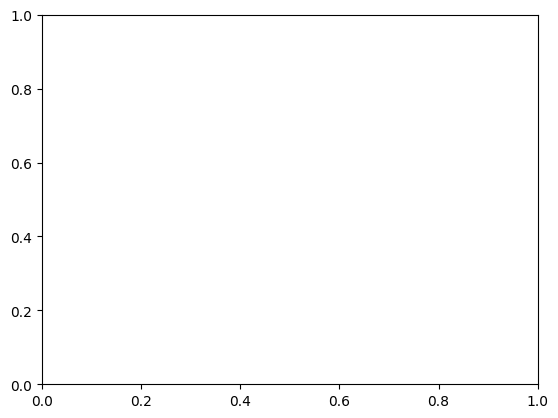

In [ ]:
plot_histogram(counts)